# Demo

[...]

In [1]:
import ducc0

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import healpy as hp
from beamconv import ScanStrategy
import qpoint as qp

[...]

In [2]:
# reading cls from .txt file
cls = np.loadtxt('../ancillary/wmap7_r0p03_lensed_uK_ext.txt',unpack=True) # Cl in uK^2
ell, cls = cls[0], cls[1:]

# calculating alm from cls
lmax=128
np.random.seed(25) # why do I need it?
alm = hp.synalm(cls, lmax=lmax, new=True, verbose=True) # uK

# calculating map0 from alm
map0 = hp.alm2map(alm, 512)

#fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
#plt.axes(ax1)
#hp.mollview(map0[0],title='input map (T)', hold=True)
#plt.axes(ax2)
#hp.mollview(map0[1],title='input map (Q)', hold=True)
#plt.axes(ax3)
#hp.mollview(map0[2],title='input map (Q)', hold=True)
#plt.show()

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


### Setting up beamconv
<mark>QUESTION:</mark> I wanted to produce <b>noisy</b> TODs by exploiting the functionality of <code>ducc0</code>. My idea was to generate the clean TODs from <code>beamconv</code> and add the noise signal. This procedure should be done detector-by-detector. I wanted to produce the TOD of a single detector (not a pair!) in order to have a minimal version of this functionality. Why setting <code>no_pairs=True</code> doesn't work?

In [3]:
# setting up ScanStrategy and its options
fwhm = 40
beam_opts = dict(lmax=lmax,
                 fwhm=fwhm,        # Gaussian co-pol beam, so only specify FWHM (arcmin)
                 btype='Gaussian',
                 no_pairs=True)    #isn't this the correct way to use a SINGLE DETECTOR?

[...]

In [4]:
ctime0 = 1510000000
mlen = 1 * 24 * 60 * 60        # Mission length in seconds

mmax = 2
nside_spin = 128
preview_pointing = False
verbose = True

ss = ScanStrategy(duration=mlen,
        external_pointing=True,
        theta_antisun=45.,
        theta_boresight = 50.,
        freq_antisun = 192.348, 
        freq_boresight = 0.314, 
        sample_rate = 19.1,
        jitter_amp=0.0,
        location='space',
        ctime0=ctime0)

scan_opts = dict(
        q_bore_func=ss.litebird_scan,
        ctime_func=ss.litebird_ctime,
        use_litebird_scan=True,
        q_bore_kwargs=dict(),
        ctime_kwargs=dict(),
        max_spin=mmax,
        nside_spin=nside_spin,
        preview_pointing=preview_pointing,
        verbose=verbose,
        save_tod=True) #add HWP here

Why if I re-run the cell below it scans with 4 detectors?

In [5]:
# create a square grid of Gaussian beams (how is f.o.v. related to the number of beams?)
ss.create_focal_plane(nrow=1, ncol=1, fov=1, **beam_opts)
#ss.create_focal_plane(nrow=3, ncol=3, fov=3, **beam_opts)

# calculate tods in ten chunks (they are 10, right?)
chunks = ss.partition_mission(0.1 * ss.mlen * ss.fsamp)

# allocate and assign parameters for mapmaking
ss.allocate_maps(nside=128)

ss.scan_instrument_mpi(alm, **scan_opts)

# solve for the maps
maps, cond, proj = ss.solve_for_map(return_proj = True)


Scanning with 2 detectors
[rank 000]: working on: r000c000A, r000c000B
[rank 000]:	Working on chunk 000: samples 0-165024
Implementing litebird scan
[rank 000]:	Working on chunk 001: samples 165024-330048
Implementing litebird scan
[rank 000]:	Working on chunk 002: samples 330048-495072
Implementing litebird scan
[rank 000]:	Working on chunk 003: samples 495072-660096
Implementing litebird scan
[rank 000]:	Working on chunk 004: samples 660096-825120
Implementing litebird scan
[rank 000]:	Working on chunk 005: samples 825120-990144
Implementing litebird scan
[rank 000]:	Working on chunk 006: samples 990144-1155168
Implementing litebird scan
[rank 000]:	Working on chunk 007: samples 1155168-1320192
Implementing litebird scan
[rank 000]:	Working on chunk 008: samples 1320192-1485216
Implementing litebird scan
[rank 000]:	Working on chunk 009: samples 1485216-1650240
Implementing litebird scan


In [6]:
# parameters for generating noise with ducc0
sigma = 10
f_min=1e-4
f_knee=1e-1
f_samp=19.1
slope=-1.7
nsamp = int(0.1 * ss.mlen * ss.fsamp)

# setting up and fillind TODs (clean, noisy and noise-only) 
clean_TOD = np.empty((1,1,int(ss.mlen*ss.fsamp)))
noisy_TOD = np.empty((1,1,int(ss.mlen*ss.fsamp)))
noise_TOD = np.empty((1,1,int(ss.mlen*ss.fsamp)))

<mark>QUESTION:</mark> I'm using <code>ss.data()</code> get the TOD. Given that <code>beams[0][0]</code> is a pair of detectors, what is the TOD that I'm getting?

In [7]:
for dx in np.arange(1):
    for dy in np.arange(1):
        gen = ducc0.misc.OofaNoise(sigma, f_min, f_knee, f_samp, slope)
        for chunk in np.arange(10):
            inp = np.random.normal(0.,1.,(nsamp,))
            noise = gen.filterGaussian(inp)
            clean_data = ss.data(chunks[chunk],ss.beams[dx][dy],data_type='tod')
            noisy_data = clean_data + noise
            clean_TOD[dx,dy,int(chunk*ss.mlen*ss.fsamp/10):int((chunk+1)*ss.mlen*ss.fsamp/10)] = clean_data
            noisy_TOD[dx,dy,int(chunk*ss.mlen*ss.fsamp/10):int((chunk+1)*ss.mlen*ss.fsamp/10)] = noisy_data
            noise_TOD[dx,dy,int(chunk*ss.mlen*ss.fsamp/10):int((chunk+1)*ss.mlen*ss.fsamp/10)] = noise

In [8]:
ss.beams[0]

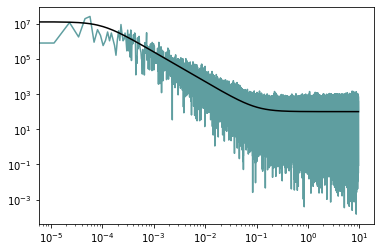

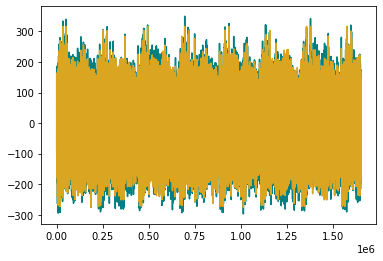

In [9]:
# evaluating power spectrum
ps = np.abs(np.fft.fft(noise_TOD[0,0,:]))**2 / (nsamp*10)
time_step = 1. / f_samp
freqs = np.fft.fftfreq(noise_TOD[0,0,:].size, time_step)
ps_theory = sigma**2 * ((freqs**2+f_knee**2)/(freqs**2+f_min**2))**(-slope/2)

# plotting
#plt.plot(freqs[idx], ps[idx])
plt.loglog(freqs[:ps.size//2],ps[:ps.size//2],'cadetblue')
plt.loglog(freqs[:ps.size//2],ps_theory[:ps.size//2],'black')
plt.show()

plt.plot(noisy_TOD[0,0,:],'teal')
plt.plot(clean_TOD[0,0,:],'goldenrod')
plt.show()